In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = 'My Drive/Bachelor' 
# replace with your Github username 
GIT_USERNAME = "godlinn" 
# definitely replace with your
GIT_TOKEN = "bb1d2da9562f11a96d713d71187b25b0dfef7000"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "deep-clustering-losses" 

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
# !mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  /content/drive/My Drive/Bachelor
GIT_PATH:  https://bb1d2da9562f11a96d713d71187b25b0dfef7000@github.com/godlinn/deep-clustering-losses.git


In [ ]:
%cd "{PROJECT_PATH}"    # Change directory to the location defined in project_path
!git clone "{GIT_PATH}" # clone the github repository

[Errno 2] No such file or directory: '/content/drive/My Drive/Bachelor # Change directory to the location defined in project_path'
/content
Cloning into 'deep-clustering-losses'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [46]:
!git add *
!git commit -m "added count loss; added gitignore; added autoencoders"
!git push origin

[prototype 4aad4e1] added count loss; added gitignore; added autoencoders
 15 files changed, 302 insertions(+), 14 deletions(-)
 create mode 100644 Copy of fashion-mnist.ipynb
 create mode 100644 DatasetLoad.py
 create mode 100644 __pycache__/DatasetLoad.cpython-36.pyc
 rewrite __pycache__/ImageDataset.cpython-36.pyc (67%)
 rewrite __pycache__/Util.cpython-36.pyc (61%)
 create mode 100644 conv_ae.py
 rewrite fashion-mnist.ipynb (81%)
 create mode 100644 material/ae_cifar.pth
 create mode 100644 material/ae_cifar_1kk.pth
 create mode 100644 material/ae_cifar_1kk_scheduler.pth
 create mode 100644 material/autoencoder_cinic
Counting objects: 17, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (17/17), done.
Writing objects: 100% (17/17), 18.74 MiB | 8.92 MiB/s, done.
Total 17 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 4 local objects.
To https://github.com/godlinn/deep-clustering-losses.git
   c073f2f..4aad4e1  prototype -> 

In [2]:
%cd drive/My\ Drive/Bachelor/deep-clustering-losses

/content/drive/My Drive/Bachelor/deep-clustering-losses


# Import

In [3]:
# Importing all necessary libraries

# ipython magic functions for automatic reloading code changes in .py files
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict
# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

# specify base paths

base_path = "material"
model_name = "autoencoder.pth"


print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)

Versions
torch:  1.7.0+cu101
torchvision:  0.8.1+cu101
numpy:  1.18.5
scikit-learn: 0.22.2.post1


In [4]:
# some utility functions, you can skip those in the beginning
from Util import denormalize
from Util import plot_images
from Util import detect_device
from Util import encode_batchwise
from Util import decode_batchwise
from Util import predict_batchwise
from Util import evaluate_batchwise

# Autoencoder
from Autoencoder import Autoencoder

-----------------
# 2) Applying the autoencoder to MNIST

## First we have to download the MNIST data set

In [5]:
## Load CIFAR
from DatasetLoad import load_cifar

data = load_cifar('./data')

# print("Data Set Information")
# print("Number of data points: ", data.shape[0])
# print("Number of dimensions: ", data.shape[1])
# print(f"Mean: {data.mean():.2f}, Standard deviation: {data.std():.2f}")
# print(f"Min: {data.min():.2f}, Max: {data.max():.2f}")
# print("Number of classes: ", len(set(labels.tolist())))
# print("Class distribution:\n", sorted(Counter(labels.tolist()).items()))

Plot some images to see if everything worked:


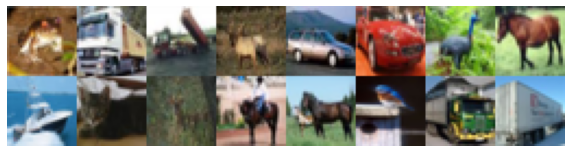

In [6]:
print("Plot some images to see if everything worked:")

# plot_images(denormalize(data[0:16], mean=0, std=1))
plot_images(data[0:16])

## Train Autoencoder

In [31]:
from conv_ae import ConvAE

In [24]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
# Set all parameters needed for training

# The size of the mini-batch that is passed in each trainings iteration
batch_size = 256
# The learning rate specifies the step size of the gradient descent algorithm
learning_rate = 1e-3
# Maximum training iterations
training_iterations = 50000
#Model
# model = Autoencoder(input_dim=3*32*32, embedding_size=32)
# model = ConvAE(n_channels=32, n_classes=10)
model = ConvAutoencoder()
# Set device on which the model should be trained on (For most of you this will be the CPU)
device = detect_device()
print("Use device: ", device)

# ds = torch.utils.data.TensorDataset(*(data, labels))

# create a Dataloader to train the autoencoder in mini-batch fashion
trainloader = torch.utils.data.DataLoader(data[:20000],
                                          batch_size=batch_size,
                                          # sample random mini-batches from the data
                                          shuffle=True,
                                          drop_last=False)

cifartest = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False)
# create a Dataloader to test the autoencoder in mini-batch fashion (Important for validation)
testloader = torch.utils.data.DataLoader(cifartest,
                                         batch_size=batch_size,
                                         # Note that we deactivate the shuffling 
                                         shuffle=False,
                                         drop_last=False)

# load model to device
model.to(device)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# define loss function
loss_fn = torch.nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

# path to were we want to save/load the model to/from
pretrained_model_name = "pretrained_" + model_name
pretrained_model_path = os.path.join(base_path, pretrained_model_name)


Use device:  cuda


In [26]:
# Specify if you want to train the model (this will overwrite the existing model)
# or load our already pretrained model:
TRAIN = True

if TRAIN:
    i = 0
    # training loop
    while(i < 1000):
          for batch in trainloader:
            # load batch on device
            batch = batch.to(device)
            # reset gradients from last iteration
            optimizer.zero_grad()
            reconstruction = model(batch)
            loss = loss_fn(reconstruction, batch)
            # calculate gradients and reset the computation graph
            loss.backward()
            # update the internal params (weights, etc.)
            optimizer.step()
            # scheduler.step(loss)
            if i > training_iterations:
                print("Stop training")
                break
            if i % 1000 == 0:
                print(f"Iteration {i}/{training_iterations} - Reconstruction loss: {loss.item():.4f}")
            i += 1
    # save model
    torch.save(model.state_dict(), 'material/ae_cifar_conv_simple.pth')
else:
    # load model
    state_dict = torch.load('material/autoencoder_cinic', map_location=device)
    model.load_state_dict(state_dict)

Iteration 0/50000 - Reconstruction loss: 0.0620
Iteration 1000/50000 - Reconstruction loss: 0.0073


Original Images


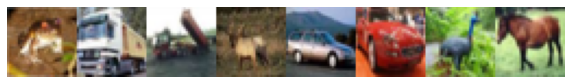

Reconstructed Images


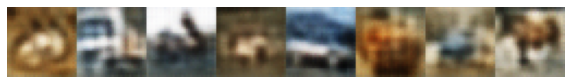

In [27]:
# Plot how well we are at reconstructing the data:
to_plot = 8
print("Original Images")
plot_images(denormalize(data[0:to_plot], mean=0, std=1))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(reconstruction)

In [32]:
## TODO: Debug or use simpler with flatten

model_cae = ConvAE(n_channels=3, n_classes=10)
model_cae = model_cae.fit(trainloader=trainloader,epochs=training_iterations,start_lr=learning_rate, end_lr=None, device=device)

RuntimeError: ignored

## Plotting the embedded space with PCA


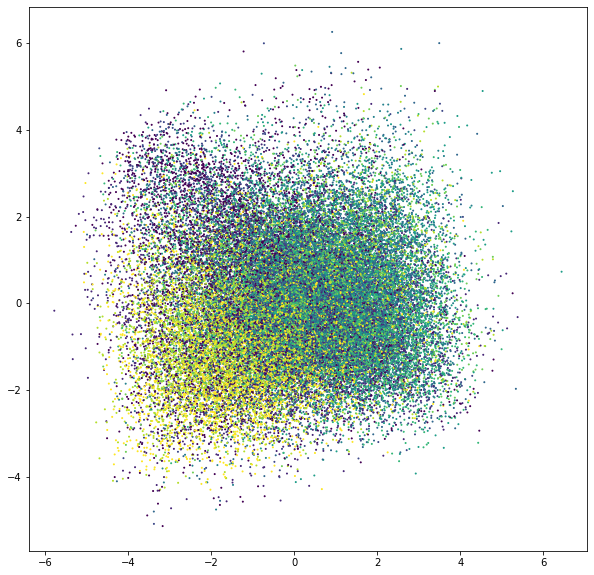

In [ ]:
(embedded_data, labels) = encode_batchwise(testloader, model, device)
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(embedded_data)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, s=1);

-------------------
# Implementing the deep clustering algorithms DEC/IDEC 

Before we get into the details of DEC and IDEC lets see how well a simple baseline like the k-means algorithm performs on our trained autoencoder. K-Means applied on the raw MNIST digits achieves a NMI of about 0.5.

In [ ]:
n_clusters = len(set(labels.tolist()))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmi = normalized_mutual_info_score(labels, kmeans.labels_)
print(f"NMI: {nmi:.4f}")

NMI: 0.0016


## Background information about DEC
(We skip this and show directly how to implement DEC)

Deep Embedded Clustering (DEC) is one of the first techniques that simultaneously learns a feature representation and cluster assignments with a deep neural network. The general outline of this technique has inspired further research due to its impressive results. The main contribution of DEC is the formulation of a loss function that quantifies a desirable clustering representation. For this they use the Student's t-distribution, with $\alpha=1$ degrees of freedom, to measure the distance between embedded points $z_i$ and centroids $\mu_j$, see equation $q_{i,j}$. The rationale behind this distribution is that it is heavier tailed than e.g. a gaussian or delta distribution, which allows for similar features to be mapped close together (local structure preservation) and can be evaluated fast, this idea has been adapted from t-sne.

$$
\begin{equation}
q_{i,j} = \frac{(1+\|{z_i-\mu_j}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}{\Sigma_j'(1+\|{z_i-\mu_j'}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}
\label{DEC_SoftAssignment}
\end{equation}
$$

From $q_{i,j}$ they measure the KL Divergence from a desired target distribution $P$:

$$
\begin{equation}
L = KL(P||Q) = \Sigma_i\ \Sigma_j\ p_{i,j}\ \log\frac{p_{i,j}}{q_{i,j}}
\label{KL_DivergenceDEC}
\end{equation}
$$

The authors define the following desirable properties for a target distribution $P$:
 - strengthen predictions
 - put more emphasis on data points assigned with high confidence 
 - normalize loss contribution for each centroid to prevent large clusters from distorting the hidden feature space

$p_{i,j}$ in the equation below fulfills the above properties:

$$
\begin{equation}
p_{i,j} = \frac{\frac{q^2_{i,j}}{f_j}}{\Sigma_{j'} \frac{q^2_{i,j'}}{f_{j'}}}
\label{DEC_P}
\end{equation}
$$

The term $q_{i,j}^2$ strengthens high confidence predictions which leads to improved cluster purity. The term $f_i = \Sigma_i q_{i,j}$ renormalizes by frequency per cluster while summing up the soft cluster frequencies.

DEC uses a previously pretrained autoencoder (as we did above) and then in the following steps the initial clustering is fine tuned to improve the results via backpropagating the gradients from the loss function $L = KL(P||Q)$. This jointly optimizes cluster centers $\mu_j$ and  network parameters $\theta$ until less than a threshold value of $T$ percent of points change their cluster assignment.
 


## Implementation of DEC soft cluster prediction:

$$
\begin{equation}
q_{i,j} = \frac{(1+\|{z_i-\mu_j}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}{\Sigma_j'(1+\|{z_i-\mu_j'}\|^{\frac{2}{\alpha}})^{-\frac{\alpha+1}{2}}}
\label{DEC_SoftAssignment}
\end{equation}
$$


In [ ]:
from UtilDEC import dec_prediction

## Implementation of DEC auxiliary target distribution:
$$
\begin{equation}
p_{i,j} = \frac{\frac{q^2_{i,j}}{f_j}}{\Sigma_{j'} \frac{q^2_{i,j'}}{f_{j'}}}
\label{DEC_P}
\end{equation}
$$

In [ ]:
from UtilDEC import dec_compression_value

## KL Divergence term:
$$
\begin{equation}
L = KL(P||Q) = \Sigma_i\ \Sigma_j\ p_{i,j}\ \log\frac{p_{i,j}}{q_{i,j}}
\label{KL_DivergenceDEC}
\end{equation}
$$

In [ ]:
from UtilDEC import dec_compression_loss_fn

# Implemented Loss Functions

## 1. Simple Contrastive Loss

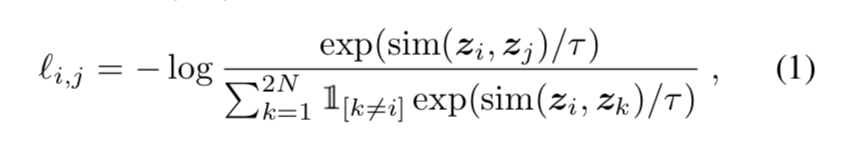

sim(z1, z2) = z1.T * z2 / ||z1|| ||z2||

In [ ]:
# find sim for all i,j, where i is in batch and j is in au_batch

def scl_sim_batchwise1(batch, au_batch, tau):
  nom = batch.mm(au_batch.t())
  batch_norm = torch.linalg.norm(batch, dim=1)
  au_batch_norm = torch.linalg.norm(au_batch, dim=1)
  denom = batch_norm.unsqueeze(1) * au_batch_norm * tau
  return nom/(denom + 1e-16)

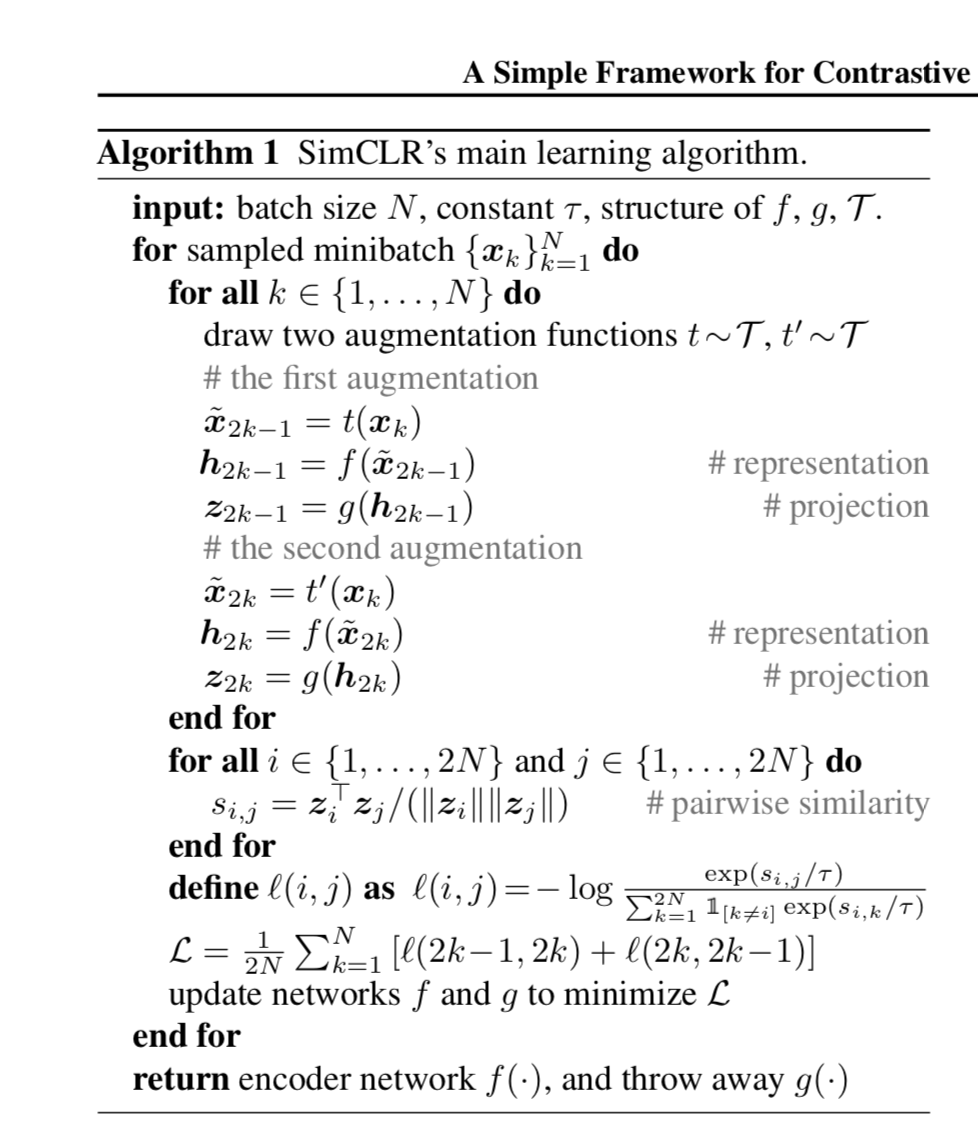

In [ ]:
# find all sim between positive pairs
def scl(batch, au_batch, tau):
  c1 = torch.cat((batch , au_batch), 0)
  c2 = torch.cat((au_batch, batch), 0) ## detach? look closer: tensor from same tensors
  sim_pairwise = torch.exp(scl_sim_batchwise1(c1, c2, tau))
  
  nom = sim_pairwise.diag()
  denom = torch.sum(sim_pairwise, dim=0) - nom
  positive_losses = -torch.log(nom/(denom + 1e-16))
  return positive_losses.sum()/batch.size(0)

In [ ]:
b = torch.Tensor([[1,2,3],[4,5,6]])
ba = torch.Tensor([[7,8,9],[10,11,12]])
print(b)
print(ba)
scl(b, ba, 0.5)
# scl_sim_batchwise1(b, ba, 0.5)

## ResNet50 without pretraining: long
## ResNet18 instead of self-trained autoencoder

tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor([[ 7.,  8.,  9.],
        [10., 11., 12.]])


tensor(2.2363)

## Spatial Contrast

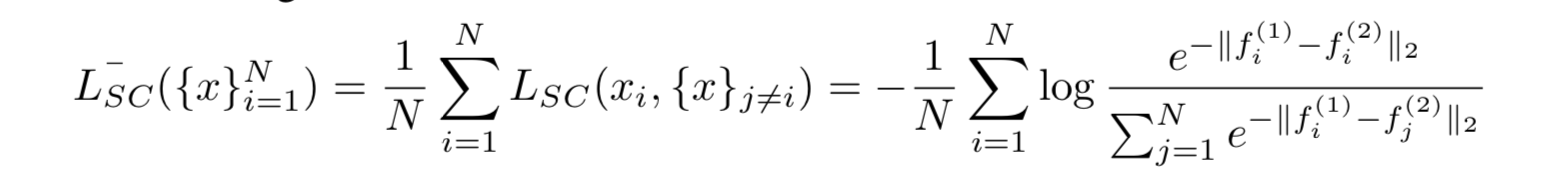

In [ ]:
def spat_contrast(x1, x2):
    x1_concat = x1.repeat(1,x1.shape[0])
    ## TODO: replace repeate with unsqueeze
    ## check out pytorch euqlidian distance (cdist)
    x2_concat = x2.flatten().repeat(x2.shape[0],1)
    diff = x1_concat - x2_concat
    diff = diff.reshape(x1.size(0) * diff.size(0), x1.size(1))
    norm_diff = torch.linalg.norm(diff, dim=1)
    ## todo: check if can spare reshape and by using norm with dim param
    return norm_diff.reshape(x1.size(0), x1.size(0))

In [ ]:
def spat_contrast_loss(x1, x2):
  contrast = spat_contrast(x1, x2)
  ce_loss = torch.nn.CrossEntropyLoss()
  return ce_loss(contrast, torch.tensor([*range(0, contrast.size()[1])]))

## TODO: implement manually and compare; if different use manual
def spat_contrast_loss_manual(x1, x2):
  contrast = spat_contrast(x1, x2)
  nom = contrast.diag()
  denom = torch.sum(contrast, dim=0)
  positive_losses = torch.log(nom/(denom + 1e-16))
  return -(positive_losses.sum()/x1.size(0))

In [ ]:
x = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
print(spat_contrast_loss(x, x))
print(spat_contrast_loss_manual(x,x))

tensor(8.8959)
tensor(inf)


## Counting loss

In [ ]:
##TODO: tweak M since 10 is param for counting. check mse btw a negative pair
def counting_loss(downsampled, tiles, contrast_downsampled, M=10):
  tiles = torch.cat(tiles, 1)
  mse_loss = torch.nn.MSELoss()
  mse_positive = mse_loss(downsampled, tiles)
  mse_negative = mse_loss(contrast_downsampled, tiles)
  return mse_positive + torch.max(torch.Tensor([0, M - mse_negative]))

## TODO: check what other losses can be used instead of mse, better for images.
## option variant: l1
## huber (smooth align) loss? 
## paper: comparison of losses for images

In [ ]:
x = torch.Tensor([[1,2,3,4],[4,5,6,7],[7,8,9,10],[11,12,13,14]])
print(x)
t = torch.Tensor([[1],[4],[7],[11]])
counting_loss(x,(t,t,t,t),x)


## image rotation: check code, probaly usual softwmax

tensor([[ 1.,  2.,  3.,  4.],
        [ 4.,  5.,  6.,  7.],
        [ 7.,  8.,  9., 10.],
        [11., 12., 13., 14.]])


tensor(10.)

## Putting all together in a class

Note the centers $\mu$ and assignments $q$ are jointly learned together

In [ ]:
from DEC import DEC

In [ ]:
# Load model again
model = Autoencoder()
state_dict = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device);

In [ ]:
n_rounds = 40000
# Setup DEC
init_centers = kmeans.cluster_centers_
cluster_module = DEC(init_centers).to(device)

# Reduce learning_rate from pretraining by a magnitude of 10
dec_learning_rate = learning_rate*0.1

# Note: We now optimize the autoencoder and the DEC parameters jointly together
optimizer = torch.optim.Adam(list(model.parameters()) + list(cluster_module.parameters()), lr=dec_learning_rate)

# path to were we want to save/load the model to/from

dec_model_name = "dec_" + model_name
dec_model_path = os.path.join(base_path, dec_model_name)
dec_path = os.path.join(base_path, "dec.pth")

In [ ]:
TRAIN = True

if TRAIN:
    # DEC Training loop
    i = 0
    while(i < n_rounds):  # each iteration is equal to an epoch
        for batch in trainloader:
            batch_data = batch[0].to(device)
            embedded = model.encode(batch_data)
            reconstruction = model.decode(embedded)

            ae_loss = loss_fn(batch_data, reconstruction)

            cluster_loss = cluster_module.loss_dec_compression(embedded)

            # Reconstruction loss is not included in DEC
            loss = cluster_loss
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
                print(f"{i}/{n_rounds} cluster_loss:{cluster_loss.item():.4f} NMI:{nmi:.4f}"
                      f" Irrelevant for DEC:[ae_loss:{ae_loss.item():.4f} total_loss: {(ae_loss.item() + cluster_loss.item()):.4f}]")

            if i > n_rounds:
                print("Stop training")
                break
            i += 1
    
    # save model
    torch.save(model.state_dict(), dec_model_path)
    # save DEC
    torch.save(cluster_module.state_dict(), dec_path)
else:
    # load model
    state_dict = torch.load(dec_model_path, map_location=device)
    model.load_state_dict(state_dict)
    # load DEC
    state_dict = torch.load(dec_path, map_location=device)
    cluster_module.load_state_dict(state_dict)


nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
print(f"Final NMI:{nmi:.4f}") 
    


0/40000 cluster_loss:1.4471 NMI:0.6219 Irrelevant for DEC:[ae_loss:0.0482 total_loss: 1.4953]
1000/40000 cluster_loss:0.4249 NMI:0.6832 Irrelevant for DEC:[ae_loss:0.2043 total_loss: 0.6291]
2000/40000 cluster_loss:0.3552 NMI:0.6770 Irrelevant for DEC:[ae_loss:0.2374 total_loss: 0.5927]
3000/40000 cluster_loss:0.3121 NMI:0.6686 Irrelevant for DEC:[ae_loss:0.2522 total_loss: 0.5643]
4000/40000 cluster_loss:0.2541 NMI:0.6676 Irrelevant for DEC:[ae_loss:0.2907 total_loss: 0.5448]
5000/40000 cluster_loss:0.2415 NMI:0.6626 Irrelevant for DEC:[ae_loss:0.3144 total_loss: 0.5560]
6000/40000 cluster_loss:0.2057 NMI:0.6612 Irrelevant for DEC:[ae_loss:0.3281 total_loss: 0.5338]
7000/40000 cluster_loss:0.1905 NMI:0.6587 Irrelevant for DEC:[ae_loss:0.3516 total_loss: 0.5421]
8000/40000 cluster_loss:0.1848 NMI:0.6575 Irrelevant for DEC:[ae_loss:0.4058 total_loss: 0.5906]
9000/40000 cluster_loss:0.1521 NMI:0.6582 Irrelevant for DEC:[ae_loss:0.4140 total_loss: 0.5661]
10000/40000 cluster_loss:0.1569 N

## Reconstruct again to see what happened by distorting the space with DEC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Images


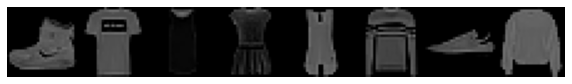

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


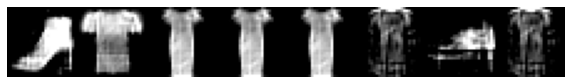

In [ ]:
to_plot = 8
print("Original Images")
plot_images(denormalize(data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

## Plot embedded space again with PCA

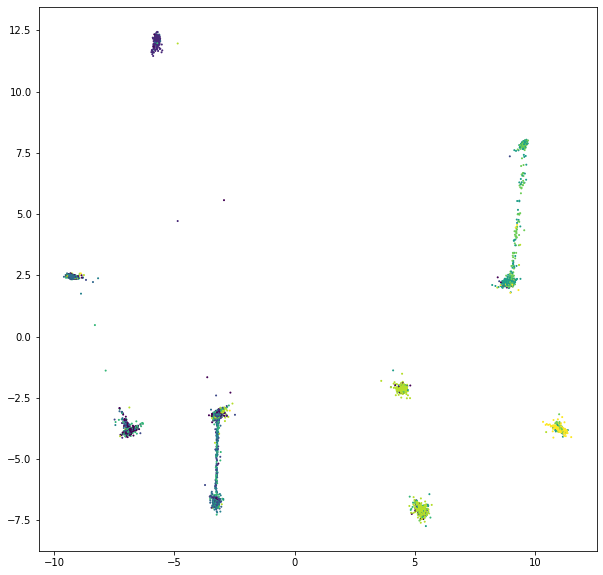

In [ ]:
embedded_data = encode_batchwise(testloader, model, device)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embedded_data)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, s=1);

# IDEC

One problem of DEC is that during fine tuning the local structure of the embedding can be lost, which weakens its representational power and can decrease clustering performance. This is due to discarding the decoder part of the autoencoder.  The algorithm IDEC suggest a new approach which keeps the decoder part during fine tuning. The new loss function below combines the reconstruction loss $L_r$ and clustering loss $L_c$, where $\gamma>0$ controls the degree of space distortion: 
 
 $$
 \begin{equation}
  L = L_r + \gamma L_c 
 \label{IDEC_LossFunction}
 \end{equation}
 $$
 

In [ ]:
# Load model again
model = Autoencoder()
state_dict = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device);

In [ ]:
n_rounds = 40000
degree_of_space_distortion = 0.1

# Setup IDEC
init_centers = kmeans.cluster_centers_
cluster_module = DEC(init_centers).to(device)

# Reduce learning_rate from pretraining by a magnitude of 10
idec_learning_rate = learning_rate*0.1

# Note: We now optimize the autoencoder and the DEC parameters jointly together
optimizer = torch.optim.Adam(list(model.parameters()) + list(cluster_module.parameters()), lr=idec_learning_rate)

# path to were we want to save/load the model to/from

idec_model_name = "idec_" + model_name
idec_model_path = os.path.join(base_path, idec_model_name)
idec_path = os.path.join(base_path, "idec.pth")

In [ ]:
# IDEC Training loop

n_rounds = 40000
train_round_idx = 0
# gamma parameter

TRAIN = True

if TRAIN:
    # IDEC Training loop
    i = 0
    while(i < n_rounds):  # each iteration is equal to an epoch
        for batch in trainloader:
            batch_data = batch[0].to(device)
            embedded = model.encode(batch_data)
            reconstruction = model.decode(embedded)

            ae_loss = loss_fn(batch_data, reconstruction)
            cluster_loss = cluster_module.loss_dec_compression(embedded)
            
            # Reconstruction loss is now included
            # L = L_r + \gamma L_c 
            loss = ae_loss + degree_of_space_distortion * cluster_loss 
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
                print(f"{i}/{n_rounds} cluster_loss:{cluster_loss.item():.4f} NMI:{nmi:.4f}"
                      f" ae_loss:{ae_loss.item():.4f} total_loss: {(ae_loss.item() + cluster_loss.item()):.4f}]")

            if i > n_rounds:
                print("Stop training")
                break
            i += 1
    
    # save model
    torch.save(model.state_dict(), idec_model_path)
    # save IDEC
    torch.save(cluster_module.state_dict(), idec_path)
else:
    # load model
    state_dict = torch.load(idec_model_path, map_location=device)
    model.load_state_dict(state_dict)
    # load IDEC
    state_dict = torch.load(idec_path, map_location=device)
    cluster_module.load_state_dict(state_dict)

nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
print(f"Final NMI:{nmi:.4f}") 

0/40000 cluster_loss:1.4222 NMI:0.6218 ae_loss:0.0457 total_loss: 1.4679]
1000/40000 cluster_loss:0.8080 NMI:0.6582 ae_loss:0.0535 total_loss: 0.8615]
2000/40000 cluster_loss:0.6855 NMI:0.6648 ae_loss:0.0522 total_loss: 0.7378]
3000/40000 cluster_loss:0.5589 NMI:0.6668 ae_loss:0.0523 total_loss: 0.6113]
4000/40000 cluster_loss:0.4914 NMI:0.6677 ae_loss:0.0509 total_loss: 0.5423]
5000/40000 cluster_loss:0.4075 NMI:0.6681 ae_loss:0.0503 total_loss: 0.4578]
6000/40000 cluster_loss:0.3856 NMI:0.6692 ae_loss:0.0570 total_loss: 0.4426]
7000/40000 cluster_loss:0.3262 NMI:0.6693 ae_loss:0.0514 total_loss: 0.3776]
8000/40000 cluster_loss:0.3121 NMI:0.6698 ae_loss:0.0483 total_loss: 0.3604]
9000/40000 cluster_loss:0.3026 NMI:0.6699 ae_loss:0.0509 total_loss: 0.3535]
10000/40000 cluster_loss:0.2895 NMI:0.6700 ae_loss:0.0531 total_loss: 0.3426]
11000/40000 cluster_loss:0.2622 NMI:0.6696 ae_loss:0.0533 total_loss: 0.3155]
12000/40000 cluster_loss:0.2244 NMI:0.6699 ae_loss:0.0484 total_loss: 0.2728]

## Reconstruct again to see what happened by distorting the space with IDEC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Images


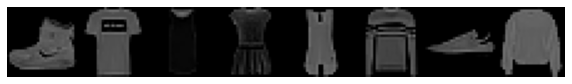

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


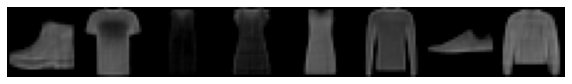

In [ ]:
to_plot = 8
print("Original Images")
plot_images(denormalize(data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

## Plot embedded space again with PCA

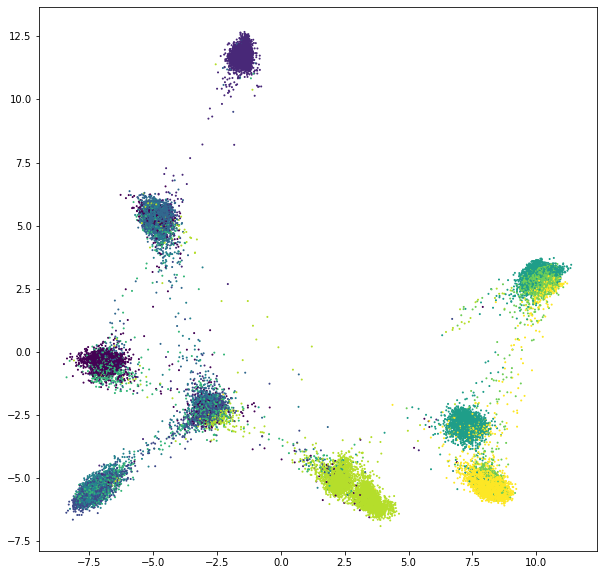

In [ ]:
embedded_data = encode_batchwise(testloader, model, device)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embedded_data)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, s=1);

# Simple Contrastive Loss Training

In [ ]:
# Simple Contrastive Loss Training loop

n_rounds = 40000
train_round_idx = 0
# gamma parameter

TRAIN = True

if TRAIN:
    # IDEC Training loop
    i = 0
    while(i < n_rounds):  # each iteration is equal to an epoch
        for batch in trainloader:
            
            batch_data = batch[0].to(device)
            embedded = model.encode(batch_data)
            reconstruction = model.decode(embedded)

            ae_loss = loss_fn(batch_data, reconstruction)
            cluster_loss = cluster_module.loss_dec_compression(embedded)
            
            # Reconstruction loss is now included
            # L = L_r + \gamma L_c 
            loss = ae_loss + degree_of_space_distortion * cluster_loss 
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 1000 == 0:
                nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
                print(f"{i}/{n_rounds} cluster_loss:{cluster_loss.item():.4f} NMI:{nmi:.4f}"
                      f" ae_loss:{ae_loss.item():.4f} total_loss: {(ae_loss.item() + cluster_loss.item()):.4f}]")

            if i > n_rounds:
                print("Stop training")
                break
            i += 1
    
    # save model
    torch.save(model.state_dict(), idec_model_path)
    # save IDEC
    torch.save(cluster_module.state_dict(), idec_path)
else:
    # load model
    state_dict = torch.load(idec_model_path, map_location=device)
    model.load_state_dict(state_dict)
    # load IDEC
    state_dict = torch.load(idec_path, map_location=device)
    cluster_module.load_state_dict(state_dict)

nmi = evaluate_batchwise(testloader, model, cluster_module, device)            
print(f"Final NMI:{nmi:.4f}") 

NameError: ignored